# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

¿Where is the best location for a Specialty Coffee Shop in Santiado of Chile?

For this project we will be targeted to stakeholders interested in opening an Specialty Coffee Shop in Santiago, Chile.

Coffee is a fundamental part of food culture around the world and the specialty coffee is a growing market. 

Coffee consumption has increased dramatically and the consumers in general are moving toward higher-quality, gourmet coffee. For years, you could only get coffee beans and grounds from a few companies and regions, but the foodservice trend toward higher-quality and craft foods has opened up many other options. Nowadays, there is a nearly endless selection of coffee from all over the world that wouldn't have been available a few decades ago.

The age of coffee consumers also has decreased. The change was identified through the findings of a 2017 study on coffee consumption. The study was published in the journal Annals of Internal Medicine and involved more than 520,000 people. Their findings showed that drinking coffee regularly could improve life expectancy. After these results were published, the National Coffee Association (NCA) discovered that the percentage of daily coffee drinkers increased from 57% to 62% in the course of a year. In the United States alone, 44% of those coffee consumers are millennials. (https://www.webstaurantstore.com/blog/2356/top-coffee-trends.html)

There are 941 coffee shops in the metropolitan area of Santiago and this number has been increasing in the last 10 years. (http://santiagocoffeelovers.cl/cafeterias-especialidad-nuevo-mundo-sabores-experiencias/)

We will explore the metropolitan area of Santiago to find the best locations based on a good quality of life with less number of coffee shops and places frequented by young people.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing coffee shops in the areas explored
* venues like museums, art gallerys, cultural centers or farmer markets (places frecuented by young people)
* a zone with a good quality of life

Following data sources will be needed to extract/generate the required information:
* Zones of Santiago and their geografical location using **wikipedia** and the **HERE geocode**
* number and location of coffee shops using **Foursquare API**
* venues by zone and their categories

### Communes of Santiago

First les't find the zones Santiago is divided using the data provided by Wikipedia and after that with the geocode let't find the latitude and longitude of every zone

#### Libraries

In [1]:
import numpy as np #Numpy Library
import pandas as pd #Panda Library
from bs4 import BeautifulSoup #BeautifulSoup to read the html

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
!conda install -c conda-forge geocoder
import geocoder
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab#
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline 

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib as mpl
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
geocoder                  1.38.1                     py_0    conda-forge
Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
geopy                     1.19.0                     py_0    conda-forge


From Wikipedia I'm going to get the different zones of Santiago, they are called Communes
https://es.wikipedia.org/wiki/Anexo:Comunas_de_Santiago_de_Chile

Also on this page are relevant data like the population, poverty, quality of life index

In [2]:
source=requests.get('https://es.wikipedia.org/wiki/Anexo:Comunas_de_Santiago_de_Chile').text #reading the page

In [3]:
soup = BeautifulSoup(source,'lxml') #to get the table

In [4]:
table = soup.find('table', attrs={'class':'wikitable sortable'})
df = pd.read_html(str(table))[0]
column_name = df.loc[[0]]
lista = df.drop([0])
lista.columns = ['Comnune','Location','Population (2017)','Households(2002)','Population density (2002)','population growth','Quality of life index(2018)','Poverty']
lista.head()

,Comnune,Location,Population (2017),Households(2002),Population density (2002),population growth,Quality of life index(2018),Poverty
1,Cerrillos,surponiente,80832,19811,4329.08,12.9%,45.32 (43),8.3
2,Cerro Navia,norponiente,132622,35277,13482.91,-10.7%,36.33 (86),17.5
3,Conchalí,norte,126955,32609,12070.29,-4.4%,40.54 (74),8.0
4,El Bosque,sur,162505,42808,12270.72,-7.3%,38.43 (83),15.8
5,Estación Central,surponiente,147041,32357,9036.31,16.6%,48.17 (28),7.3


In [5]:
lista.dtypes

Comnune                        object
Location                       object
Population (2017)              object
Households(2002)               object
Population density (2002)      object
population growth              object
Quality of life index(2018)    object
Poverty                        object
dtype: object

We need to convert the numeric columns to float

In [6]:
lista["Poverty"] = lista["Poverty"].astype("float")

We are going to need to split the column Quality of life index to obtain the percentaje and the index 

In [7]:
lista["Quality of life index(2018)"]=lista["Quality of life index(2018)"].replace('\(','', regex=True).replace('\)','', regex=True).replace(',','.', regex=True)

In [8]:
lista['Quality of Life'],lista['Index Quality of Life']=lista["Quality of life index(2018)"].str.split(" ",1).str

In [9]:
lista['Quality of Life']=lista['Quality of Life'].astype("float")

In [10]:
lista['Index Quality of Life']=lista['Index Quality of Life'].astype("int")

Also the population column needs to be converted to integer

In [11]:
lista["Population (2017)"] = (lista["Population (2017)"].astype("int"))

And we drop columns that not are necesary

In [12]:
lista.drop(['Households(2002)','Population density (2002)','population growth','Quality of life index(2018)'], axis=1, inplace=True)

In [13]:
lista.dtypes

Comnune                   object
Location                  object
Population (2017)          int64
Poverty                  float64
Quality of Life          float64
Index Quality of Life      int64
dtype: object

In [14]:
lista.head()

,Comnune,Location,Population (2017),Poverty,Quality of Life,Index Quality of Life
1,Cerrillos,surponiente,80832,8.3,45.32,43
2,Cerro Navia,norponiente,132622,17.5,36.33,86
3,Conchalí,norte,126955,8.0,40.54,74
4,El Bosque,sur,162505,15.8,38.43,83
5,Estación Central,surponiente,147041,7.3,48.17,28


In [15]:
print ('Population of Santiago: ',str(lista['Population (2017)'].sum()))

Population of Santiago:  6179183


We set the Commune as the index

In [16]:
lista.set_index('Comnune', inplace=True)

In [17]:
lista.index.name = None

In [18]:
lista.head()

,Location,Population (2017),Poverty,Quality of Life,Index Quality of Life
Cerrillos,surponiente,80832,8.3,45.32,43
Cerro Navia,norponiente,132622,17.5,36.33,86
Conchalí,norte,126955,8.0,40.54,74
El Bosque,sur,162505,15.8,38.43,83
Estación Central,surponiente,147041,7.3,48.17,28


some plots we can obtain with this data

We are going to plot the Quality of Life of every commune

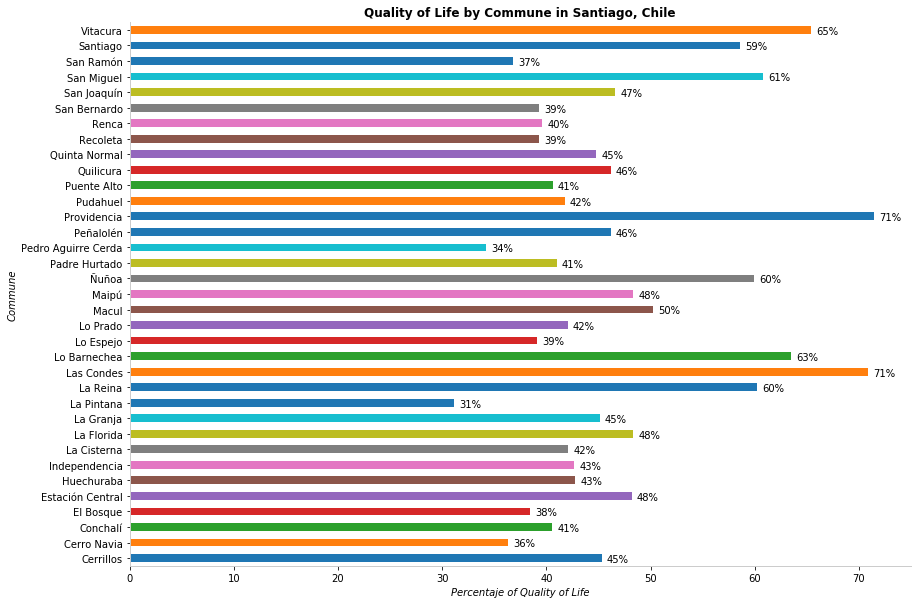

In [19]:
ax = lista['Quality of Life'].plot(kind='barh', figsize=(14, 10))
ax.set_title('Quality of Life by Commune in Santiago, Chile', weight='bold')
ax.set_ylabel('Commune',fontstyle='italic')
ax.set_xlabel('Percentaje of Quality of Life',fontstyle='italic')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(width/100), (p.get_x()+width +0.5 , p.get_y()))
    
ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

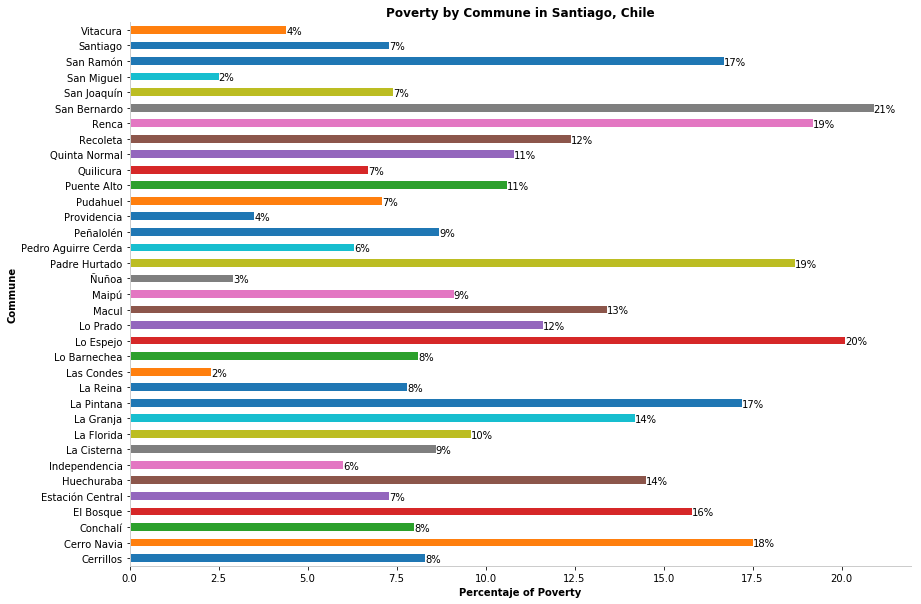

In [20]:
ax = lista['Poverty'].plot(kind='barh', figsize=(14, 10))
ax.set_title('Poverty by Commune in Santiago, Chile', weight='bold')
ax.set_ylabel('Commune', weight='bold')
ax.set_xlabel('Percentaje of Poverty', weight='bold')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(width/100), (p.get_x()+width, p.get_y()))
    
ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

For our analysis we are going to need the communes with higger Quality of Life and less Poverty.

With a histogram we can know the aprox number of communes we are going to analize

Text(0,0.5,'Number of Communes')

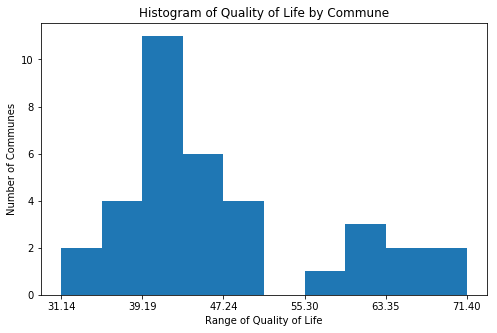

In [21]:
count, bin_edges = np.histogram(lista['Quality of Life'],5)
hist = lista['Quality of Life'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)
hist.set_title('Histogram of Quality of Life by Commune')
hist.set_xlabel('Range of Quality of Life')
hist.set_ylabel('Number of Communes')

In [22]:
QoLSorted =lista.sort_values('Quality of Life',ascending=True)

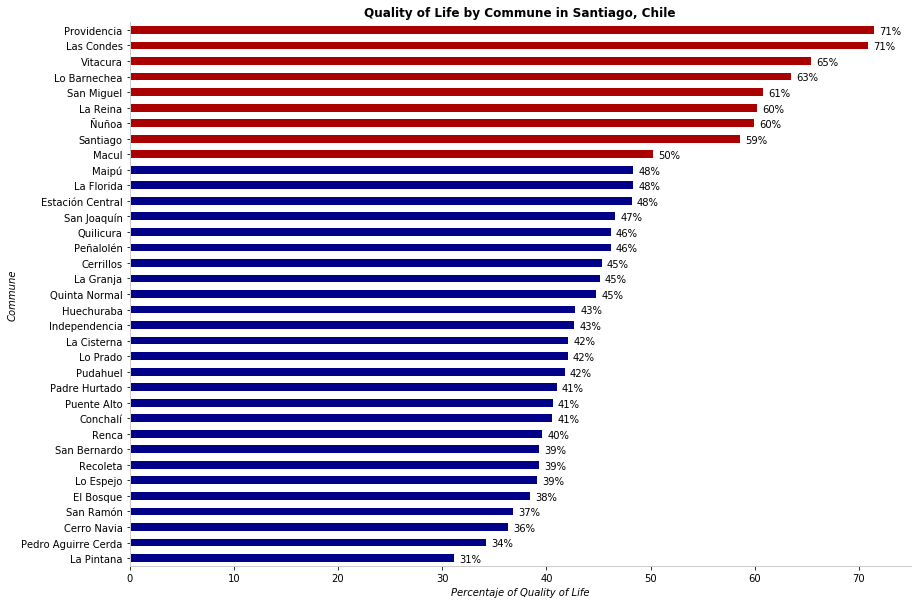

In [23]:
ax = QoLSorted['Quality of Life'].plot(kind='barh', figsize=(14, 10), color=['#AA0000' if row['Quality of Life'] > 50 else '#000088' for name,row in QoLSorted.iterrows()],)
ax.set_title('Quality of Life by Commune in Santiago, Chile', weight='bold')
ax.set_ylabel('Commune',fontstyle='italic')
ax.set_xlabel('Percentaje of Quality of Life',fontstyle='italic')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(width/100), (p.get_x()+width +0.5 , p.get_y()))
    
ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

Text(0,0.5,'Number of Communes')

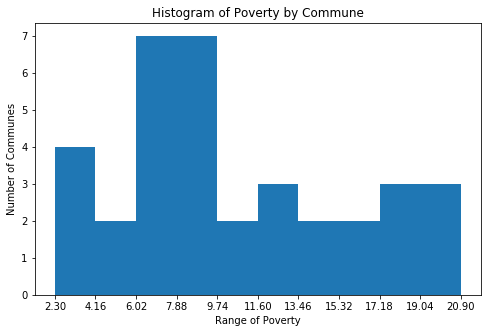

In [24]:
count, bin_edges = np.histogram(lista['Poverty'],10)
hist = lista['Poverty'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)
hist.set_title('Histogram of Poverty by Commune')
hist.set_xlabel('Range of Poverty')
hist.set_ylabel('Number of Communes')

In [25]:
PovertySorted =lista.sort_values('Poverty',ascending=False)

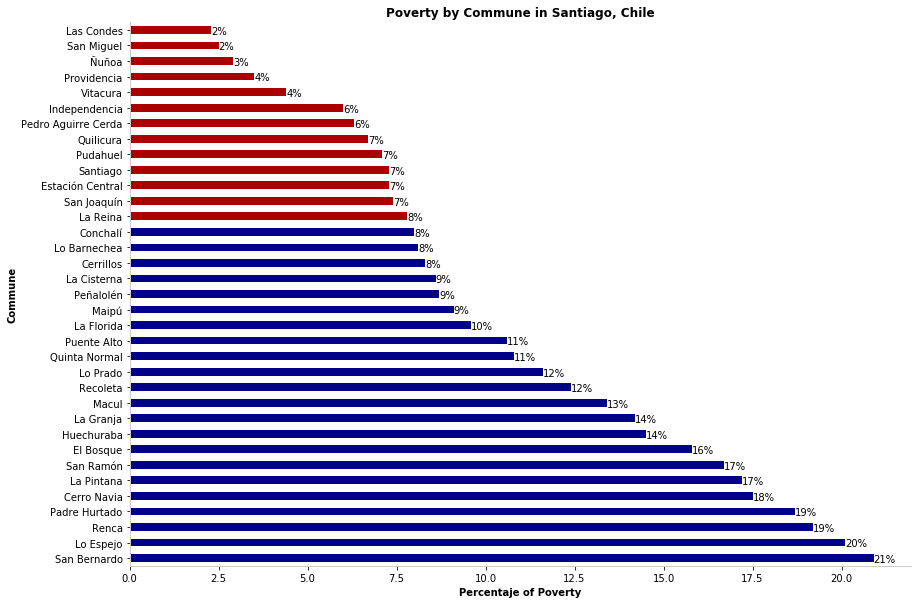

In [26]:
ax = PovertySorted['Poverty'].plot(kind='barh', figsize=(14, 10), color=['#AA0000' if row['Poverty'] < 7.88 else '#000088' for name,row in PovertySorted.iterrows()],)
ax.set_title('Poverty by Commune in Santiago, Chile', weight='bold')
ax.set_ylabel('Commune', weight='bold')
ax.set_xlabel('Percentaje of Poverty', weight='bold')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(width/100), (p.get_x()+width, p.get_y()))
    
ax.patch.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['left'].set_linewidth(1)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

To obtain the latitude and longitude of every commune we are using the geocode HERE

In [27]:
# The code was removed by Watson Studio for sharing.

In [28]:
lista['Latitude']=0
lista['Longitude']=0
for i in range(0, len(lista)):
    ubicacion = '\''+lista.index[i]+',Santiago,Chile\''
    g=geocoder.here(ubicacion,app_id=ID,app_code=CODE) # I'm using the geocoder HERE
   # print(i,"-",ubicacion,':',g.lat,' ',g.lng)
    lista['Latitude'].iloc[i] = g.lat
    lista['Longitude'].iloc[i]= g.lng

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [29]:
address = 'Santiago, Chile'
g=geocoder.here(address,app_id=ID,app_code=CODE)
SCL_lat = g.lat
SCL_lng = g.lng
print('The geograpical coordinates of Santiago are {}, {}.'.format(SCL_lat, SCL_lng))

The geograpical coordinates of Santiago are -33.43722, -70.65002.


In [30]:
lista.head()

,Location,Population (2017),Poverty,Quality of Life,Index Quality of Life,Latitude,Longitude
Cerrillos,surponiente,80832,8.3,45.32,43,-33.48862,-70.70079
Cerro Navia,norponiente,132622,17.5,36.33,86,-33.43472,-70.72992
Conchalí,norte,126955,8.0,40.54,74,-33.39659,-70.67104
El Bosque,sur,162505,15.8,38.43,83,-33.55567,-70.66590
Estación Central,surponiente,147041,7.3,48.17,28,-33.45101,-70.67941


We filter the data by the Quality of Life and Poverty, this sub-dataframes are going to help to choose the communes to analyze

In [31]:
lista_QOL = lista[lista['Quality of Life'] >= 50]
lista_QOL.shape

(9, 7)

In [32]:
lista_POV = lista[lista['Poverty']<=7.88]
lista_POV.shape

(13, 7)

*The following map is going to display all the communes in a blue circle, the communes with better Quality of life in a red cicle and the communes with the less poverty in a yellow circle*

In [33]:
map_santiago = folium.Map(location=[SCL_lat, SCL_lng], zoom_start=11.5)

# add markers to map
for lat, lng, index in zip(lista['Latitude'], lista['Longitude'], lista.index):
    label = index
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=20,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_santiago)  
    
for lat, lng, label1 in zip(lista_QOL['Latitude'], lista_QOL['Longitude'], lista_QOL['Quality of Life']):
    label = 'QOL: '+format(label1)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='red',
        fill=True,
        fill_color='#f9c8b8',
        fill_opacity=0.2,
        parse_html=False).add_to(map_santiago)    
    
for lat, lng, label2 in zip(lista_POV['Latitude'], lista_POV['Longitude'], lista_POV['Poverty']):
    label = 'Poverty: '+format(label2)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#f9f8cf',
        fill_opacity=0.2,
        parse_html=False).add_to(map_santiago)    
map_santiago

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Santiago with a good quality of life and low poverty.

Based on the map visualization of the communes and the communes with low poverty and high quality of life we decided what communes to explore. 

The communes with the higher Quality of Life are almost equivalent to the communes with lower poverty, so we can explore the communes with a Quality of Life with more than 50 percent.

With Fourquare we are going to get the venues by commune and clasify it by their categories.

With the categories we can choose the communes with less coffee shops.

As final step we can visualize the choose commune and detect the venues frecuented by young people to recomend the best places to open a coffee shop

## Analysis <a name="analysis"></a>

Based on the communes displayed in the map, I'm going to use the sub-dataframe with the communes with higger Quality of Life

In [34]:
# The code was removed by Watson Studio for sharing.

In [35]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We are going to use the following funtion to obtain the venues per commune in a radius of 2000

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Commune', 
                  'Commune Latitude', 
                  'Commune Longitude', 
                  'Venue',
                  'Venue ID', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
lista_QOL.head()

,Location,Population (2017),Poverty,Quality of Life,Index Quality of Life,Latitude,Longitude
La Reina,nororiente,92787,7.8,60.23,6,-33.43929,-70.55638
Las Condes,nororiente,294838,2.3,70.86,2,-33.41657,-70.59553
Lo Barnechea,nororiente,105833,8.1,63.44,4,-33.36199,-70.51445
Macul,suroriente,116534,13.4,50.19,18,-33.48178,-70.59921
Ñuñoa,nororiente,208237,2.9,59.89,7,-33.45521,-70.59388


In [38]:
LIMIT = 100
santiago_venues = getNearbyVenues(names=lista_QOL.index, latitudes=lista_QOL['Latitude'], longitudes=lista_QOL['Longitude'])

La Reina
Las Condes
Lo Barnechea
Macul
Ñuñoa
Providencia
San Miguel
Santiago
Vitacura


In [39]:
print(santiago_venues.shape)
santiago_venues.head()

(898, 8)


,Commune,Commune Latitude,Commune Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,La Reina,-33.43929,-70.55638,Ayar Uchu,536e730b498ef89be33b3521,-33.438140,-70.556692,Peruvian Restaurant
1,La Reina,-33.43929,-70.55638,Caramagnola Bike & Beer & Drinks,5355ba40498e9269994dfc62,-33.439192,-70.557031,Bar
2,La Reina,-33.43929,-70.55638,Starbucks,4b6c4086f964a520ca2b2ce3,-33.438917,-70.561624,Coffee Shop
3,La Reina,-33.43929,-70.55638,La Pizzarra,4bd7a5595cf276b094d79b00,-33.438599,-70.564722,Pizza Place
4,La Reina,-33.43929,-70.55638,Element,4bd62cfb6798ef3bd8c6648d,-33.439194,-70.561602,Latin American Restaurant


In [40]:
print('There are {} uniques categories.'.format(len(santiago_venues['Venue Category'].unique())))

There are 193 uniques categories.


In [41]:
# one hot encoding
santiago_onehot = pd.get_dummies(santiago_venues[['Venue Category']], prefix="", prefix_sep="")

santiago_onehot['Commune'] = santiago_venues['Commune'] 

# move commune column to the first column
fixed_columns = [santiago_onehot.columns[-1]] + list(santiago_onehot.columns[:-1])
santiago_onehot = santiago_onehot[fixed_columns]

santiago_onehot.head()

,Commune,Accessories Store,Adult Boutique,American Restaurant,Amphitheater,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Thrift / Vintage Store,Toy / Game Store,Track,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Wine Bar,Wine Shop,Yoga Studio
0,La Reina,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,La Reina,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,La Reina,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,La Reina,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,La Reina,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
santiago_onehot.shape

(898, 194)

In [43]:
santiago_grouped = santiago_onehot.groupby('Commune').mean().reset_index()
santiago_grouped.head()

,Commune,Accessories Store,Adult Boutique,American Restaurant,Amphitheater,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Thrift / Vintage Store,Toy / Game Store,Track,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Wine Bar,Wine Shop,Yoga Studio
0,La Reina,0.0,0.00,0.02,0.01,0.0,0.00,0.00,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.000000,0.0,0.00,0.00
1,Las Condes,0.0,0.01,0.01,0.00,0.0,0.01,0.00,0.0,0.0,...,0.0,0.01,0.00,0.00,0.00,0.00,0.000000,0.0,0.02,0.02
2,Lo Barnechea,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.010204,0.0,0.00,0.00
3,Macul,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,...,0.0,0.01,0.01,0.00,0.00,0.00,0.000000,0.0,0.00,0.00
4,Providencia,0.0,0.00,0.00,0.00,0.0,0.00,0.01,0.0,0.0,...,0.0,0.00,0.00,0.02,0.01,0.01,0.000000,0.0,0.01,0.00


Now we are going to get the top 10 venues for commune

In [44]:
num_top_venues = 10

for hood in santiago_grouped['Commune']:
    print("----"+hood+"----")
    temp = santiago_grouped[santiago_grouped['Commune'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----La Reina----
                  venue  freq
0           Pizza Place  0.07
1                  Park  0.06
2                Bakery  0.05
3      Sushi Restaurant  0.04
4  Gym / Fitness Center  0.04
5    Chinese Restaurant  0.04
6   Peruvian Restaurant  0.04
7        Sandwich Place  0.03
8             Multiplex  0.03
9        Breakfast Spot  0.02


----Las Condes----
                venue  freq
0               Hotel  0.07
1         Coffee Shop  0.06
2  Italian Restaurant  0.05
3         Pizza Place  0.04
4               Plaza  0.04
5              Bakery  0.04
6                Café  0.03
7      Clothing Store  0.03
8        Burger Joint  0.03
9   Indian Restaurant  0.03


----Lo Barnechea----
                  venue  freq
0                   Gym  0.07
1            Restaurant  0.06
2           Coffee Shop  0.05
3      Sushi Restaurant  0.04
4         Shopping Mall  0.04
5          Burger Joint  0.03
6              Pharmacy  0.03
7            Steakhouse  0.02
8  Gym / Fitness Center  0.02
9

In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [46]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Commune']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
communes_venues_sorted = pd.DataFrame(columns=columns)
communes_venues_sorted['Commune'] = santiago_grouped['Commune']

for ind in np.arange(santiago_grouped.shape[0]):
    communes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(santiago_grouped.iloc[ind, :], num_top_venues)

communes_venues_sorted

,Commune,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,La Reina,Pizza Place,Park,Bakery,Sushi Restaurant,Chinese Restaurant,Peruvian Restaurant,Gym / Fitness Center,Sandwich Place,Multiplex,Breakfast Spot
1,Las Condes,Hotel,Coffee Shop,Italian Restaurant,Bakery,Plaza,Pizza Place,Café,Clothing Store,Park,Burger Joint
2,Lo Barnechea,Gym,Restaurant,Coffee Shop,Shopping Mall,Sushi Restaurant,Burger Joint,Pharmacy,Sandwich Place,Bakery,Motorcycle Shop
3,Macul,Chinese Restaurant,Pharmacy,Sandwich Place,Pizza Place,Restaurant,Bakery,Soccer Field,Peruvian Restaurant,Sushi Restaurant,Ice Cream Shop
4,Providencia,Pizza Place,Coffee Shop,Sandwich Place,Café,French Restaurant,Restaurant,Park,Burger Joint,Plaza,Indian Restaurant
5,San Miguel,Sushi Restaurant,Restaurant,Pizza Place,Flea Market,Plaza,Latin American Restaurant,Bakery,Peruvian Restaurant,Sandwich Place,Bar
6,Santiago,Coffee Shop,Bookstore,Sandwich Place,Café,Art Museum,Hotel,Restaurant,Pizza Place,Burger Joint,Plaza
7,Vitacura,Hotel,Coffee Shop,Peruvian Restaurant,Steakhouse,Pizza Place,Bistro,Seafood Restaurant,Restaurant,Italian Restaurant,Ice Cream Shop
8,Ñuñoa,Bakery,Café,Pizza Place,Restaurant,Coffee Shop,Peruvian Restaurant,Italian Restaurant,Gym,Plaza,Yoga Studio


So, we have the following communes without coffee shops or Cafés in their top 10
- San Miguel
- Macul
- La Reina

In [51]:
lista.loc[['La Reina','Macul','San Miguel']]

,Location,Population (2017),Poverty,Quality of Life,Index Quality of Life,Latitude,Longitude
La Reina,nororiente,92787,7.8,60.23,6,-33.43929,-70.55638
Macul,suroriente,116534,13.4,50.19,18,-33.48178,-70.59921
San Miguel,sur,107954,2.5,60.82,5,-33.48576,-70.64995


San Miguel has a better Quality of Life and a less Poverty and based in this criteria we are going to explore the San Miguel commune

In [52]:
santiago_venues[(santiago_venues['Commune']=='San Miguel')]['Venue Category'].unique()

array(['Park', 'Japanese Restaurant', 'South American Restaurant', 'Gym',
       'Pizza Place', 'Bar', 'Martial Arts Dojo',
       'Latin American Restaurant', 'Plaza', 'Soccer Stadium',
       'Fried Chicken Joint', 'Thai Restaurant', 'Breakfast Spot',
       'Sushi Restaurant', 'Thrift / Vintage Store', 'Flea Market',
       'Restaurant', 'Bakery', 'Seafood Restaurant', 'Café',
       'Peruvian Restaurant', 'Coffee Shop', 'Convenience Store',
       'Food Truck', 'Hockey Arena', 'Sandwich Place', 'Ramen Restaurant',
       'Theater', 'Office', 'Falafel Restaurant', 'Gastropub',
       'Asian Restaurant', 'Liquor Store', 'Mexican Restaurant',
       'Burger Joint', 'Sports Club', 'Supermarket', 'BBQ Joint',
       'Art Gallery', 'Performing Arts Venue', 'Chinese Restaurant',
       'Playground', 'Pub', 'French Restaurant', 'Cupcake Shop',
       'Farmers Market', 'Italian Restaurant', 'Gym / Fitness Center',
       'Mediterranean Restaurant', 'Pharmacy'], dtype=object)

Based on the venues categories we are going to filter by places frecuented by young adults like art galleries, farmers market, parks, Thrift / Vintage Store, flea markets, theather and Gyms

Now we are going to explore the location of the Coffee Shops and Cafes in the commune

In [93]:
sanmiguel_venues = santiago_venues[(santiago_venues['Commune']=='San Miguel')]

In [94]:
sanmiguel_venues = sanmiguel_venues[((sanmiguel_venues['Venue Category']=='Performing Arts Venue')| (sanmiguel_venues['Venue Category']=='Farmers Market') | (sanmiguel_venues['Venue Category']=='Art Gallery'))]

In [95]:
sanmiguel_venues

,Commune,Commune Latitude,Commune Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
663,San Miguel,-33.48576,-70.64995,Factoría de Arte Santa Rosa,4e3deed68877b00cfc4f0353,-33.474593,-70.641709,Art Gallery
666,San Miguel,-33.48576,-70.64995,Casa De La Cultura San Miguel,4d263b62d2668cfa9addc5db,-33.486508,-70.651343,Performing Arts Venue
686,San Miguel,-33.48576,-70.64995,Feria Departamental,4d20a3ba86e154819d80bb3a,-33.501100,-70.660428,Farmers Market


In [96]:
coffee_venues = santiago_venues[((santiago_venues['Commune']=='San Miguel') & ((santiago_venues['Venue Category']=='Coffee Shop') | (santiago_venues['Venue Category']=='Café')))]

In [97]:
coffee_venues

,Commune,Commune Latitude,Commune Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
617,San Miguel,-33.48576,-70.64995,Cocó Café,579d50ac498e20f50df24db8,-33.497172,-70.654912,Café
621,San Miguel,-33.48576,-70.64995,Caffe Codice,513363dbe4b08f70f9cef67d,-33.498026,-70.653820,Coffee Shop
638,San Miguel,-33.48576,-70.64995,The Weekend Cafe,5505890d498ef793c4b27dde,-33.474904,-70.640551,Café


In [98]:
latitude =  lista['Latitude'].loc['San Miguel']
longitude = lista['Longitude'].loc['San Miguel']

In [99]:
map = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, venue in zip(sanmiguel_venues['Venue Latitude'], sanmiguel_venues['Venue Longitude'], sanmiguel_venues['Venue']):
    label = venue
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map)  
for lat, lng, venue in zip(coffee_venues['Venue Latitude'], coffee_venues['Venue Longitude'], coffee_venues['Venue']):
    label = venue
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#ff6600',
        fill_opacity=0.5,
        parse_html=False).add_to(map) 
map

I think the best location is near the farmer market, let go to explore the venues near the farmet market (index 668)

In [100]:
sanmiguel_venues = sanmiguel_venues.reset_index(drop=True)

In [101]:
sanmiguel_venues

,Commune,Commune Latitude,Commune Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,San Miguel,-33.48576,-70.64995,Factoría de Arte Santa Rosa,4e3deed68877b00cfc4f0353,-33.474593,-70.641709,Art Gallery
1,San Miguel,-33.48576,-70.64995,Casa De La Cultura San Miguel,4d263b62d2668cfa9addc5db,-33.486508,-70.651343,Performing Arts Venue
2,San Miguel,-33.48576,-70.64995,Feria Departamental,4d20a3ba86e154819d80bb3a,-33.501100,-70.660428,Farmers Market


In [102]:
latitude =  sanmiguel_venues['Venue Latitude'].iloc[0]
longitude = sanmiguel_venues['Venue Longitude'].iloc[0]
                                     
radius = 500
LIMIT = 100
# First we have to form the URL
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

In [103]:
results = requests.get(url).json()
#results

In [104]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [105]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Galpón Victor Manuel,Thrift / Vintage Store,-33.474211,-70.639818
1,Persa Bio Bío,Flea Market,-33.475125,-70.642763
2,Selfish,Seafood Restaurant,-33.475121,-70.641030
3,Restaurant Colapez,Peruvian Restaurant,-33.474537,-70.640558
4,Mote con Huesillo Vida Sana,Food Truck,-33.472821,-70.642293
5,Gusto Criollo,South American Restaurant,-33.474424,-70.641474
6,Gema Ramen,Ramen Restaurant,-33.474186,-70.640945
7,Restaurant El Tata,Latin American Restaurant,-33.474326,-70.644409
8,Lai Thai • Franklin,Thai Restaurant,-33.472847,-70.639672
9,Thai-Isan,Thai Restaurant,-33.476028,-70.645035


In [106]:
for lat, lng, venue in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name']):
    label = venue
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff6600',
        fill_opacity=0.5,
        parse_html=False).add_to(map) 
map

In [107]:
latitude =  sanmiguel_venues['Venue Latitude'].iloc[1]
longitude = sanmiguel_venues['Venue Longitude'].iloc[1]
                                     
radius = 500
LIMIT = 100
# First we have to form the URL
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
results = requests.get(url).json()

In [108]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Parque El Llano,Park,-33.486025,-70.650419
1,La Trava,Bar,-33.486983,-70.651810
2,Pizzas donde Vittorio,Pizza Place,-33.485138,-70.655265
3,Estadio El Llano,Soccer Stadium,-33.483194,-70.653422
4,Plaza El Llano,Plaza,-33.482050,-70.651967
5,Entre Cavas Y Ladrillos,Latin American Restaurant,-33.482376,-70.649722
6,Kioto Sushi,Sushi Restaurant,-33.484266,-70.655095
7,Cafeteria Isabel,Breakfast Spot,-33.482498,-70.650189
8,Restaurante Altue,Restaurant,-33.483100,-70.654775
9,Club De San Miguel,Seafood Restaurant,-33.487276,-70.651264


In [109]:
for lat, lng, venue in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name']):
    label = venue
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='green',
        fill=True,
        fill_color='#E7FFE3',
        fill_opacity=0.5,
        parse_html=False).add_to(map) 
map

In [110]:
latitude =  sanmiguel_venues['Venue Latitude'].iloc[2]
longitude = sanmiguel_venues['Venue Longitude'].iloc[2]
                                     
radius = 500
LIMIT = 100
# First we have to form the URL
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Museo A Cielo Abierto,Art Gallery,-33.502402,-70.660596
1,Parque Nacional Del Comic,Park,-33.502345,-70.660454
2,Feria Departamental,Farmers Market,-33.501100,-70.660428
3,Kenzen,Sushi Restaurant,-33.498985,-70.658778
4,Pipeños De Portezuelo,Wine Shop,-33.502778,-70.657814
5,Panaderia El Encanto,Bakery,-33.502030,-70.660573
6,All star santiago,Gym / Fitness Center,-33.503602,-70.661190
7,Exotic-Chile,Pet Store,-33.502548,-70.657869
8,Panaderia san pedro,Bakery,-33.499061,-70.663960


In [111]:
for lat, lng, venue in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name']):
    label = venue
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='Purple',
        fill=True,
        fill_color='#FEE3FF',
        fill_opacity=0.5,
        parse_html=False).add_to(map) 
map

This concludes our analysis. We have identified three posible locations, 

created 15 addresses representing centers of zones containing locations with low number of restaurants and no Italian restaurants nearby, all zones being fairly close to city center (all less than 4km from Alexanderplazt, and about half of those less than 2km from Alexanderplatz). Although zones are shown on map with a radius of ~500 meters (green circles), their shape is actually very irregular and their centers/addresses should be considered only as a starting point for exploring area neighborhoods in search for potential restaurant locations. Most of the zones are located in Kreuzberg and Friedrichshain boroughs, which we have identified as interesting due to being popular with tourists, fairly close to city center and well connected by public transport.

## Results and Discussion <a name="results"></a>

Our analysis shows that although there is a great number of restaurants in Berlin (~2000 in our initial area of interest which was 12x12km around Alexanderplatz), there are pockets of low restaurant density fairly close to city center. Highest concentration of restaurants was detected north and west from Alexanderplatz, so we focused our attention to areas south, south-east and east, corresponding to boroughs Kreuzberg, Friedrichshain and south-east corner of central Mitte borough. Another borough was identified as potentially interesting (Prenzlauer Berg, north-east from Alexanderplatz), but our attention was focused on Kreuzberg and Friedrichshain which offer a combination of popularity among tourists, closeness to city center, strong socio-economic dynamics *and* a number of pockets of low restaurant density.

After directing our attention to this more narrow area of interest (covering approx. 5x5km south-east from Alexanderplatz) we first created a dense grid of location candidates (spaced 100m appart); those locations were then filtered so that those with more than two restaurants in radius of 250m and those with an Italian restaurant closer than 400m were removed.

Those location candidates were then clustered to create zones of interest which contain greatest number of location candidates. Addresses of centers of those zones were also generated using reverse geocoding to be used as markers/starting points for more detailed local analysis based on other factors.

Result of all this is 15 zones containing largest number of potential new restaurant locations based on number of and distance to existing venues - both restaurants in general and Italian restaurants particularly. This, of course, does not imply that those zones are actually optimal locations for a new restaurant! Purpose of this analysis was to only provide info on areas close to Berlin center but not crowded with existing restaurants (particularly Italian) - it is entirely possible that there is a very good reason for small number of restaurants in any of those areas, reasons which would make them unsuitable for a new restaurant regardless of lack of competition in the area. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Berlin areas close to center with low number of restaurants (particularly Italian restaurants) in order to aid stakeholders in narrowing down the search for optimal location for a new Italian restaurant. By calculating restaurant density distribution from Foursquare data we have first identified general boroughs that justify further analysis (Kreuzberg and Friedrichshain), and then generated extensive collection of locations which satisfy some basic requirements regarding existing nearby restaurants. Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.